In [ ]:
!python -m pip install 'fsspec>=0.3.3'

     |████████████████████████████████| 133 kB 11.8 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from google.colab.patches import cv2_imshow


import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D

from keras.preprocessing import image 
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers

In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
%cd /content/drive/MyDrive/DrivFacce 


Default GPU Device: /device:GPU:0
/content/drive/MyDrive/DrivFacce


In [ ]:
# and creating dataframe
driver_details = pd.read_csv("drivPoints.txt")
  
# storing this dataframe in a csv file
driver_details.to_csv('drivPoints.txt', 
                  index = None)
driver_details = driver_details.astype({"fileName": str})
a = driver_details[driver_details["fileName"] == "20130529_01_Driv_001_f "]
a["label"][0]





2

In [ ]:
pd.set_option('display.max_rows', 1000)

train_image = []

imgs = os.listdir("/content/drive/MyDrive/DrivFacce/DrivImages")
i = 0
for filename in os.listdir("/content/drive/MyDrive/DrivFacce/DrivImages"):
    if filename.endswith("jpg"): 
        # Your code comes here such as 
        img = cv2.imread("DrivImages/"+filename)
        img = cv2.resize(img,(256,256))
        label_img = driver_details[driver_details["fileName"]==filename[:-4]]["label"].item()
        train_image.append([img,label_img])
        i+=1

In [ ]:
X_train= []
Y_train = []
X_test = []
Y_test = []
import random
random.shuffle(train_image)
training,test = train_image[:510][:],train_image[510:][:]
for features,labels in training:
  X_train.append(features)
  Y_train.append(labels-1)
for features,labels in test:
  X_test.append(features)
  Y_test.append(labels-1)
print (len(X_train),len(X_test))
print (len(Y_train),len(Y_test))

510 96
510 96


In [ ]:
from keras.utils import np_utils
X_train = np.array(X_train).reshape(-1,256,256,3)
X_test = np.array(X_test).reshape(-1,256,256,3)
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
print (X_train.shape) 

(510, 256, 256, 3)


In [ ]:
## Defining the input

from keras.layers import Input
vgg16_input = Input(shape = (256, 256, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#Use the generated model 
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(3, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(inputs = vgg16_input, outputs = x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = tf.keras.optimizers.SGD(lr = 0.0001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 predictions (Dense)         (None, 3)                 98307     
                                                                 
Total params: 14,812,995
Trainable params: 14,812,995
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, Y_train, batch_size = 128)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 128, callbacks=[checkpointer, earlystopper],
                                                            epochs = 30, verbose = 1, validation_data = (X_test, Y_test))

Epoch 1/30
4/3 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8902 
Epoch 1: val_loss improved from inf to 0.49549, saving model to vgg_weights_aug_setval_sgd.hdf5
3/3 [==============================] - 89s 18s/step - loss: 0.4588 - accuracy: 0.8902 - val_loss: 0.4955 - val_accuracy: 0.9062
Epoch 2/30
4/3 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.8706
Epoch 2: val_loss did not improve from 0.49549
3/3 [==============================] - 34s 8s/step - loss: 0.4948 - accuracy: 0.8706 - val_loss: 0.4956 - val_accuracy: 0.9062
Epoch 3/30
4/3 [==============================] - ETA: 0s - loss: 0.4463 - accuracy: 0.8922
Epoch 3: val_loss improved from 0.49549 to 0.49346, saving model to vgg_weights_aug_setval_sgd.hdf5
3/3 [==============================] - 35s 9s/step - loss: 0.4463 - accuracy: 0.8922 - val_loss: 0.4935 - val_accuracy: 0.9062
Epoch 4/30
4/3 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8863
Epoch 

KeyboardInterrupt: ignored

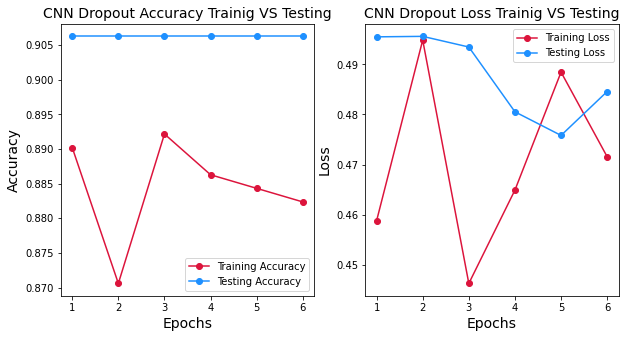

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [ ]:
vgg16_pretrained.load_weights('vgg_weights_aug_setval_sgd.hdf5')


X_test = np.array(X_test).reshape(-1,256,256,3)
prediction = vgg16_pretrained.predict(X_test)

In [ ]:
prediction[55]

array([0.04512148, 0.8783394 , 0.07653908], dtype=float32)

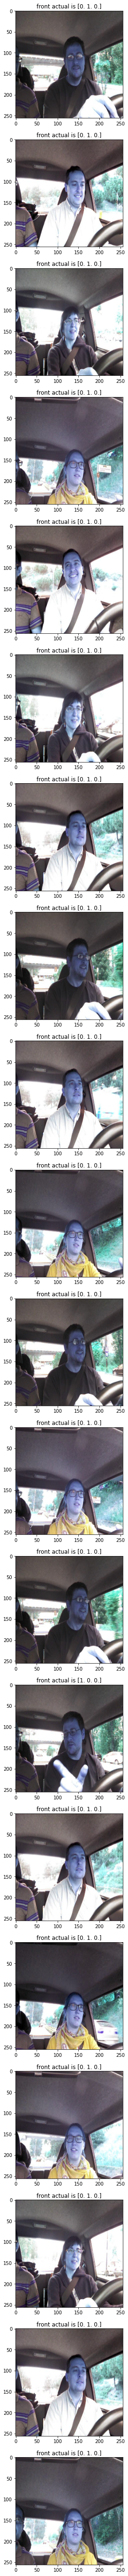

In [ ]:
# labels is the image array
tags = { "C0": "right",
"C1": "front",
"C2": "left"}
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))
j = 0 
for i in range(50,90,2):
    ax[j].imshow(X_test[i].squeeze())
    predicted_class = "C"+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[j].set_title(tags[predicted_class]+" actual is "+str(Y_test[i]))
    plt.show
    j+=1